In [ ]:
# Huggingface transformer library
!pip install transformers

In [ ]:
#Import libraries
import os
import string
import re
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statistics import *
import numpy as np
import pandas as pd
from transformers import *
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.optimizers import Adam
from tensorflow import int32
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import torch
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,History



def seed_all(seed_value):
  '''
  Input: an integer representing the seed
  Output: sets all seedables with the input seed
  '''
  random.seed(seed_value) # Python
  np.random.seed(seed_value) # cpu vars
  torch.manual_seed(seed_value) # cpu  vars
  tf.random.set_seed(seed_value)

  if torch.cuda.is_available():
      
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value) # gpu vars
      torch.backends.cudnn.deterministic = True  #needed
      torch.backends.cudnn.benchmark = False

seed_all(1)

In [ ]:
# Read train and test corpus -- pd.read_csv()
# Cast the text corpus to python string format ---astype(str)
# Replace NaN values with an empty string --- fillna("")
train = pd.read_csv("./Train.csv").astype(str).fillna("")
test = pd.read_csv("./Test.csv").astype(str).fillna("")

In [ ]:
def to_class(text):
  '''
  Input : a string that corresponds to the dataframe label
  Output: a numpy array representing the one-hot vector representation of the label string
  '''
  if text == 'Drugs': return np.array([0, 0, 0, 1])
  if text == 'Suicide': return np.array([0, 0, 1, 0])
  if text == 'Alcohol': return np.array([0, 1, 0, 0])
  if text == 'Depression': return np.array([1, 0, 0, 0])

In [ ]:
def transform(array):
  '''
  Input: a numpy array  of labels from the dataframe
  Output: a numpy array correspondng to the one-hot-vectors for all the labels
  '''
  Ynew = np.zeros((array.shape[0],4))
  for idx in range(array.shape[0]):
    Ynew[idx] = to_class(array[idx])
  return Ynew

In [ ]:
def add_features(df):
  '''
  This function is implemented to extract statistical features from the data. 
  The statistical features of interest in our experiments included two ratios,
  thus the total capital letters vrs total length of each text in the dataframe,
  then the total number of unique words vrs the total word counts in each text 
  in the corpus.

  Input: a dataframe
  Output: a daframe with added feature columns
  '''
  df['text'] = df['text'].apply(lambda x:str(x)) # Cast every text of the df to a string
  df['total_length'] = df['text'].apply(len) # Find the length of the string in df
  df['capitals'] = df['text'].apply(lambda text: sum(1 for t in text if t.isupper())) # Find the total number of capital letters per text in df
  df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                              axis=1) # Find the ratio of number of capital letters to total length of each string in df
  df['num_words'] = df.text.str.count('\S+') # Count the total number of words in each row of df
  df['num_unique_words'] = df['text'].apply(lambda text: len(set(t for t in text.split()))) # Find the total number of unique words in each string in df
  df['words_vs_unique'] = df['num_unique_words'] / df['num_words'] # Find the ratio of total number of unique words to total number of words 
  return df
 
train_text = add_features(train) # Transform the train dataframe adding two new features
 
test = add_features(test) # Transform the test dataframe adding two new features

In [ ]:
trainfeatures = train_text[['caps_vs_length', 'words_vs_unique']].fillna(0) # Extract dataframe from the transformed train corpus with two new features 
 
test_features = test[['caps_vs_length', 'words_vs_unique']].fillna(0)  # Extract dataframe from the transformed test corpus with two new features 
 

ss = StandardScaler() #Instantiate a standard scaler to scale the features
ss.fit(np.vstack((trainfeatures, test_features))) #Fit the standard scaler to both train and test features
trainfeatures = ss.transform(trainfeatures) #Transform the fitted train features


test_features = ss.transform(test_features) # Transform the fitted test features


In [ ]:
train.sample(7)

,ID,text,label,total_length,capitals,caps_vs_length,num_words,num_unique_words,words_vs_unique
464,3PJWHC2U,I feel like my life was being wasted,Depression,36,1,0.027778,8,8,1.000000
481,SEBOGNIF,Ways of distracting myself,Suicide,26,1,0.038462,4,4,1.000000
13,03TVUJ9J,"I feel empty,absent minded",Depression,26,1,0.038462,4,4,1.000000
286,V8L9C5XG,I am overwhelmed on how to deal with the issue...,Depression,66,2,0.030303,15,13,0.866667
250,WBGFUUCK,how can I be helped to come out of depression?,Depression,46,1,0.021739,10,10,1.000000
419,SJ7CFS9T,What to do in order to heal,Suicide,27,1,0.037037,7,6,0.857143
261,LGBXU9PN,Is alccohol the only form of entertainment for...,Alcohol,64,1,0.015625,11,10,0.909091


In [ ]:
maxlen = 128 # sequence maximum length
 
# Roberta Tokenizer object
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
 
# Tokenize all the train text corpus with the roberta tokenizer 
# Returns a numpy array of input ids for the tokenized train text corpus
xtrain_ids = np.array(tokenizer.batch_encode_plus(train.text.values,
                       add_special_tokens =True,
                       return_attention_mask =False,
                        return_token_type_ids = False,
                        max_length= maxlen, 
                        pad_to_max_length=True)['input_ids'])

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# Returns a numpy array of attention masks for the tokenized train text corpus
xtrain_masks = np.array(tokenizer.batch_encode_plus(train.text.values,
                  add_special_tokens =True,
                  return_attention_mask =True,
                  return_token_type_ids = False,
                  max_length= maxlen, 
                  pad_to_max_length=True)['attention_mask']
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
xtrain_ids.shape, xtrain_masks.shape

((616, 128), (616, 128))

In [ ]:
# Returns a numpy array of input ids for the tokenized test text corpus

xtest_ids = np.array(tokenizer.batch_encode_plus( test.text.values, 
                                                  add_special_tokens =True,
                                                  return_attention_mask =False,
                                                  return_token_type_ids = False,
                                                  max_length= maxlen, 
                                                  pad_to_max_length=True)['input_ids'])

# Returns a numpy array of attention masks for the tokenized test text corpus

xtest_masks =np.array(tokenizer.batch_encode_plus(test.text.values, 
                                                  add_special_tokens =True,
                                                  return_attention_mask =True,
                                                  return_token_type_ids = False,
                                                  max_length= maxlen, 
                                                  pad_to_max_length=True)['attention_mask'])


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
# Stores array of train labels
Y = train.label.values

In [ ]:
Y.shape

(616,)

In [ ]:
def get_model(): 
  '''
  Input: None
  Output: a tensorflow roberta model

  '''
  input_ids = Input((maxlen,), dtype=int32) # Input ids variable
  input_masks = Input((maxlen,),dtype=int32) # Attention masks variable
  input_stats = Input((2,), dtype=int32) # Statistical features variable


  roberta = TFRobertaModel.from_pretrained("roberta-base") # Load pretrained roberta base model
  x,_   = roberta([input_ids, input_masks])
  drop1 = Dropout(0.15, name="dropout1")(x)

  conv = Conv1D(768, 7, strides= 3, padding="same")(drop1)

  x = GlobalMaxPooling1D()(conv)

  concat = Concatenate()([x, Dense(64, activation="relu")(input_stats)])
  
  x = add([concat, Dense(832, activation= "relu")(concat)])
  x = add([x, Dense(832, activation= "relu")(x)])

  hidden = Dropout(0.15, name="dropout2")(x)
  
  flat = Flatten()(hidden)

  classification = Dense(4, activation="softmax",
                          kernel_initializer=glorot_normal(seed = 1),
                          bias_initializer=glorot_normal(seed= 1),
                          name="classification")(flat)
                          
  model = Model(inputs = [[input_ids,input_masks],input_stats], outputs=classification)
  
  optim =Adam(learning_rate=1e-5)
  model.compile(loss= "categorical_crossentropy", optimizer=optim, metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
  
  return model

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()
  plt.show()

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 128, 768), ( 124645632   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout1 (Dropout)              (None, 128, 768)     0           tf_roberta_model[0][0]       

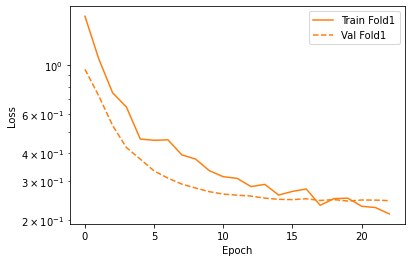

13/13 [==============================] - 2s 127ms/step


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_1 (TFRobertaMo ((None, 128, 768), ( 124645632   input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dropout1 (Dropout)              (None, 128, 768)     0           tf_roberta_model_1[0][0]   

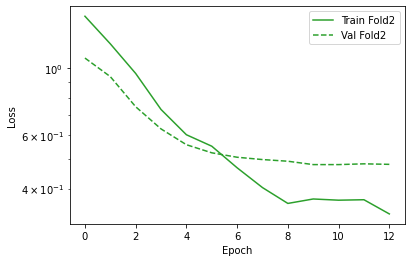

13/13 [==============================] - 2s 127ms/step


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_2 (TFRobertaMo ((None, 128, 768), ( 124645632   input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dropout1 (Dropout)              (None, 128, 768)     0           tf_roberta_model_2[0][0]   

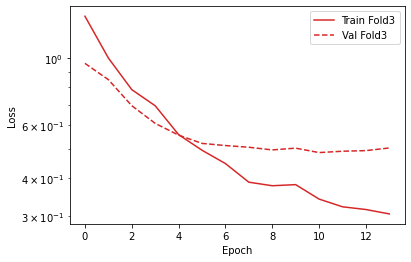

13/13 [==============================] - 2s 126ms/step


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_3 (TFRobertaMo ((None, 128, 768), ( 124645632   input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
dropout1 (Dropout)              (None, 128, 768)     0           tf_roberta_model_3[0][0]   

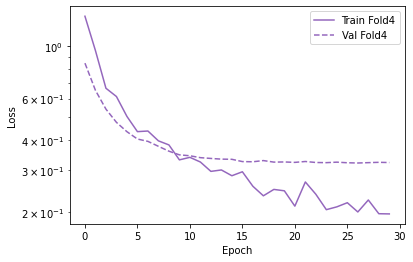

13/13 [==============================] - 2s 126ms/step


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_4 (TFRobertaMo ((None, 128, 768), ( 124645632   input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
dropout1 (Dropout)              (None, 128, 768)     0           tf_roberta_model_4[0][0]   

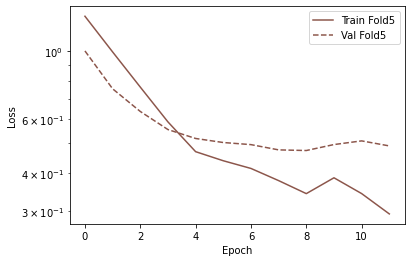

13/13 [==============================] - 2s 126ms/step


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_5 (TFRobertaMo ((None, 128, 768), ( 124645632   input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
dropout1 (Dropout)              (None, 128, 768)     0           tf_roberta_model_5[0][0]   

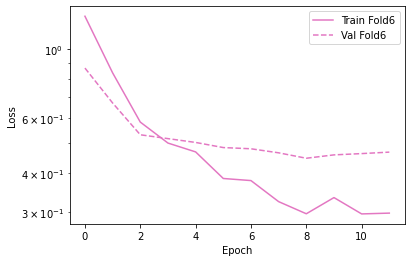

13/13 [==============================] - 2s 128ms/step


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_6 (TFRobertaMo ((None, 128, 768), ( 124645632   input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
dropout1 (Dropout)              (None, 128, 768)     0           tf_roberta_model_6[0][0]   

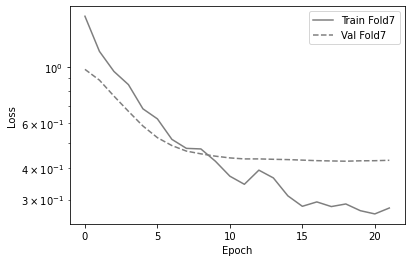

13/13 [==============================] - 2s 127ms/step


Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_7 (TFRobertaMo ((None, 128, 768), ( 124645632   input_22[0][0]                   
                                                                 input_23[0][0]                   
__________________________________________________________________________________________________
dropout1 (Dropout)              (None, 128, 768)     0           tf_roberta_model_7[0][0]   

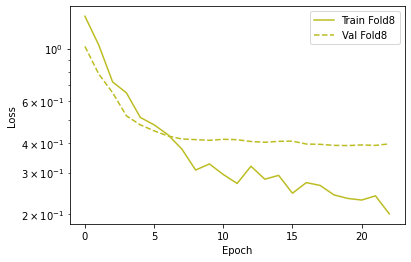

13/13 [==============================] - 2s 130ms/step


In [ ]:
history = History() 
es = EarlyStopping(monitor ="val_loss", mode="min", verbose= 1, patience = 3)
 
def scheduler(epoch):
  '''
  This function schedules the learning rate by decaying it by a factor of (epoch + 1)^ -1
  Input: an integer representing the epoch
  Output: a decimal representing the decayed learning rate
  '''
  return 1e-5/(epoch + 1)
  
rate = LearningRateScheduler(scheduler) # Schedules the learning rate

# Splits the input features [input ids, attention masks,statistical features, targets] into 8 folds
kfold = StratifiedKFold(n_splits= 8, shuffle=True, random_state = 1).split(xtrain_ids,Y) 
predictions = list() # per fold predictions variable
 
n = 0
for i, (train_idx, test_idx) in enumerate(kfold):
 
    ytrain_fold = transform(Y[train_idx]) 
    yvalid_fold = transform(Y[test_idx])  
 
    model = get_model()
    model.summary()
    
    h = model.fit([[xtrain_ids[train_idx],xtrain_masks[train_idx]], trainfeatures[train_idx]], 
            ytrain_fold, 
            batch_size= 24, 
            epochs=100, 
            callbacks =[es,rate],
            validation_data=([[xtrain_ids[test_idx],xtrain_masks[test_idx]],trainfeatures[test_idx]],yvalid_fold)
            )
    #print('Loss plot')
    n += 1
    plot_loss(h, "Fold"+str(n), n)
 
    preds = model.predict([[xtest_ids,xtest_masks],test_features], batch_size=24, verbose=1)
 
    predictions.append(preds)

In [ ]:
test_preds = np.average(predictions, axis = 0) # Average all the predictions made per fold

In [ ]:
ss = pd.read_csv("./SampleSubmission.csv")
 
ss['Depression'] = test_preds[:,0]
ss['Alcohol'] = test_preds[:,1]
ss['Suicide'] = test_preds[:,2]
ss['Drugs']  = test_preds[:,3]
 
ss.to_csv("./submission.csv", index = False)

In [ ]:
ss.sample(5)

,ID,Depression,Alcohol,Suicide,Drugs
154,H4L5M9EC,0.020668,0.389330,0.039570,0.550432
242,QTD01ME7,0.349717,0.075337,0.501000,0.073947
146,GHKPUMG2,0.501964,0.265414,0.180174,0.052448
100,BUUPSFJ1,0.990493,0.001525,0.005716,0.002267
159,HT3X6CBT,0.985912,0.000441,0.013059,0.000588
